In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve

#from f_detrend import detrend_fuction

sn.set_style('whitegrid')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words)>1 and results_follow==1 and words[0] not in omit_list:
            row_names.append(words[0])
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table

In [4]:
dates = []
for year in range(1987,2023):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

In [23]:
path="./descriptive_stats/"
file_split('rznotb_w_age3040_w.log',path,startwords=['ciclo',],endword="Total",header=None)

In [24]:
tab1 = read_table(path+'rznotb_w_age3040_w_1.log',ncols=7,rescale=100)
tab2 = read_table(path+'rznotb_w_age3040_w_2.log',ncols=7,rescale=100)
tab3 = read_table(path+'rznotb_w_age3040_w_3.log',ncols=2,rescale=100)

razones_tab = pd.concat((tab1,tab2,tab3),axis=1)
razones_tab.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
130,0.00,102842.50,31031.28,25029.95,66692.25,2167.49,0.0,3503.67,3277.64,197.62,1241.54,0.00,0.00,0.0,2170.63,5973.88
131,0.00,33071.75,34484.42,25689.49,71868.88,2071.46,0.0,1711.03,4310.69,0.00,449.58,0.00,0.00,0.0,3330.21,3971.88
132,0.00,384208.94,45430.38,24016.17,65813.56,769.08,0.0,997.93,4519.28,0.00,1066.03,37.08,74.22,0.0,2429.39,3937.49
133,88.11,85445.32,46938.00,30162.58,69814.93,3431.05,0.0,1835.98,5792.82,192.92,957.60,0.00,553.49,417.8,1188.28,3956.98
134,0.00,51943.25,41182.24,25826.54,87832.82,1226.50,0.0,2080.94,7703.63,160.70,954.90,0.00,143.07,0.0,3411.56,2907.43


In [25]:
reason_dict = {"1": "Vacaciones o dias de permiso",
               "2": "Permiso por nacimiento de un hijo",
               "3": "Excedencia por nacimiento de un hijo",
               "4": "Enfermedad, accidente o incapacidad temporal del encuestado",
               "5": "Jornada de verano, horario variable, flexible o similar",
               "6": "Actividades de representación sindical",
               "7": "Nuevo empleo en el que aún no había empezado a trabajar",
               "8": "Fijo discontinuo o trabajador estacional en la época de menor actividad",
               "9": "Mal tiempo",
               "10": "Paro parcial por razones técnicas o económicas",
               "11": "Se encuentra en expediente de regulación de empleo",
               "12": "Huelga o conflicto laboral",
               "13": "Haber recibido enseñanza o formación fuera del establecimiento",
               "14": "Razones personales o responsabilidades familiares",
               "15": "Otras razones",
               "0": "No sabe"}
razones_tab.rename(columns=reason_dict,inplace=True)
razones_tab.rename(index=date_dict,inplace=True)
razones_tab['total'] = np.sum(razones_tab,axis=1)

In [7]:
razones_tab.head()

,No sabe,Vacaciones o dias de permiso,Permiso por nacimiento de un hijo,Excedencia por nacimiento de un hijo,"Enfermedad, accidente o incapacidad temporal del encuestado","Jornada de verano, horario variable, flexible o similar",Actividades de representación sindical,Nuevo empleo en el que aún no había empezado a trabajar,Fijo discontinuo o trabajador estacional en la época de menor actividad,Mal tiempo,Paro parcial por razones técnicas o económicas,Se encuentra en expediente de regulación de empleo,Huelga o conflicto laboral,Haber recibido enseñanza o formación fuera del establecimiento,Razones personales o responsabilidades familiares,Otras razones,total
2005Q1,0.00,102842.50,31031.28,25029.95,66692.25,2167.49,0.0,3503.67,3277.64,197.62,1241.54,0.00,0.00,0.0,2170.63,5973.88,244128.45
2005Q2,0.00,33071.75,34484.42,25689.49,71868.88,2071.46,0.0,1711.03,4310.69,0.00,449.58,0.00,0.00,0.0,3330.21,3971.88,180959.39
2005Q3,0.00,384208.94,45430.38,24016.17,65813.56,769.08,0.0,997.93,4519.28,0.00,1066.03,37.08,74.22,0.0,2429.39,3937.49,533299.55
2005Q4,88.11,85445.32,46938.00,30162.58,69814.93,3431.05,0.0,1835.98,5792.82,192.92,957.60,0.00,553.49,417.8,1188.28,3956.98,250775.86
2006Q1,0.00,51943.25,41182.24,25826.54,87832.82,1226.50,0.0,2080.94,7703.63,160.70,954.90,0.00,143.07,0.0,3411.56,2907.43,225373.58


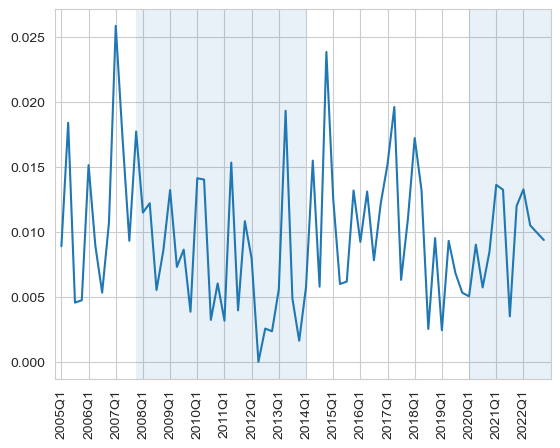

In [41]:
plt.plot(razones_tab["Razones personales o responsabilidades familiares"]/razones_tab['total'])
plt.xticks(razones_tab.index[::4],rotation=90)
plt.axvspan('2020Q1','2024Q4', alpha=0.1, lw=0)
plt.axvspan('2007Q4','2014Q1', alpha=0.1, lw=0)
plt.xlim(-1,len(razones_tab.index))
plt.show()

In [49]:
path="./descriptive_stats/"
file_split('rznotb_m_age3040_w.log',path,startwords=['ciclo',],endword="Total",header=None)
tab1 = read_table(path+'rznotb_m_age3040_w_1.log',ncols=7,rescale=100)
tab2 = read_table(path+'rznotb_m_age3040_w_2.log',ncols=7,rescale=100)
tab3 = read_table(path+'rznotb_m_age3040_w_3.log',ncols=2,rescale=100)

razones_tab_m = pd.concat((tab1,tab2,tab3),axis=1)
razones_tab_m.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
130,576.03,133003.33,1244.44,729.37,63036.27,2409.93,277.39,3969.54,4654.55,2815.53,2633.69,1256.69,172.33,2798.33,2543.18,4852.54
131,0.00,49273.35,1426.08,0.00,55767.89,2421.75,0.00,3276.87,3189.53,71.77,3231.69,0.00,613.91,284.42,331.95,5719.14
132,606.03,453790.48,0.00,277.91,51980.23,448.40,0.00,2548.20,1889.99,0.00,1855.00,160.47,709.57,293.23,551.55,1997.06
133,169.51,141111.69,3161.22,0.00,49779.49,2268.50,0.00,851.19,3496.21,1395.31,899.54,0.00,1007.32,0.00,3089.43,4549.45
134,338.03,72196.90,352.56,125.71,60934.64,2773.91,391.65,3623.91,1806.97,2500.71,4275.82,638.58,0.00,0.00,690.90,3925.02


In [9]:
razones_tab_m.rename(columns=reason_dict,inplace=True)
razones_tab_m.rename(index=date_dict,inplace=True)
razones_tab_m['total'] = np.sum(razones_tab_m,axis=1)

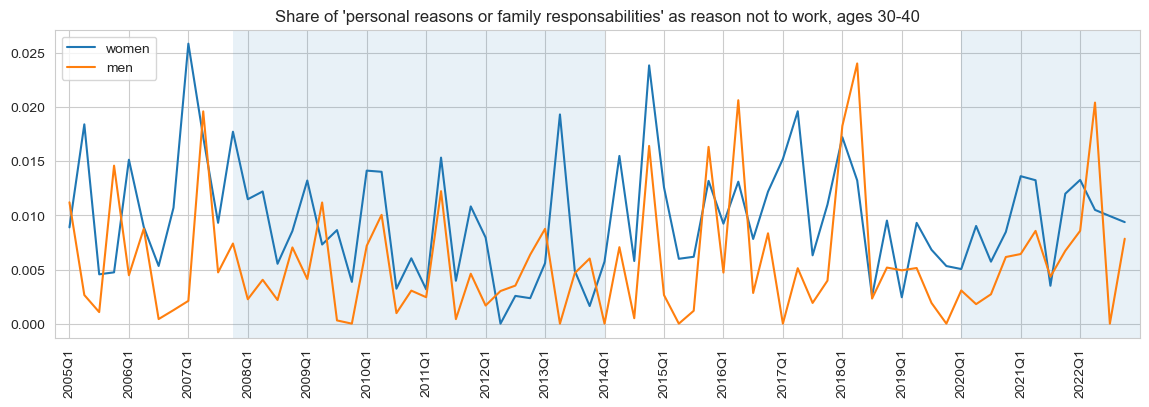

In [53]:
plt.figure(figsize=(14,4))
plt.plot(razones_tab["Razones personales o responsabilidades familiares"]/razones_tab['total'],label='women')
plt.plot(razones_tab_m["Razones personales o responsabilidades familiares"]/razones_tab_m['total'],label='men')
plt.xticks(razones_tab.index[::4],rotation=90)
plt.axvspan('2020Q1','2024Q4', alpha=0.1, lw=0)
plt.axvspan('2007Q4','2014Q1', alpha=0.1, lw=0)
plt.xlim(-1,len(razones_tab.index))
plt.legend()
plt.title("Share of 'personal reasons or family responsabilities' as reason not to work, ages 30-40")
plt.show()

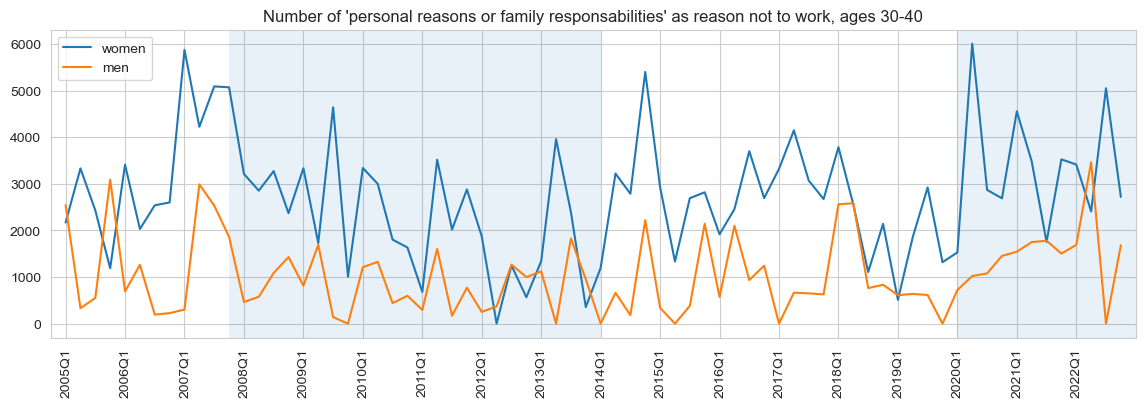

In [10]:
plt.figure(figsize=(14,4))
plt.plot(razones_tab["Razones personales o responsabilidades familiares"],label='women')
plt.plot(razones_tab_m["Razones personales o responsabilidades familiares"],label='men')
plt.xticks(razones_tab.index[::4],rotation=90)
plt.axvspan('2020Q1','2024Q4', alpha=0.1, lw=0)
plt.axvspan('2007Q4','2014Q1', alpha=0.1, lw=0)
plt.xlim(-1,len(razones_tab.index))
plt.legend()
plt.title("Number of 'personal reasons or family responsabilities' as reason not to work, ages 30-40")
plt.show()

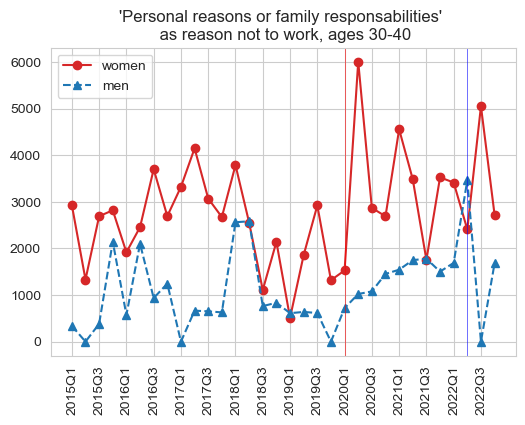

In [39]:
colors = sn.color_palette()
plt.figure(figsize=(6,4))
plt.plot(razones_tab["Razones personales o responsabilidades familiares"].loc['2015Q1':],
         label='women',marker='o',c=colors[3])
plt.plot(razones_tab_m["Razones personales o responsabilidades familiares"].loc['2015Q1':],
         label='men',marker='^',ls='--',c=colors[0])
plt.xticks(razones_tab.loc['2015Q1':].index[::2],rotation=90)
plt.axvline('2020Q1',c='r',lw=0.4)
plt.axvline('2022Q2',c='b',lw=0.4)
# plt.axvspan('2020Q1','2024Q4', alpha=0.1, lw=0)
# plt.axvspan('2007Q4','2014Q1', alpha=0.1, lw=0)
# plt.xlim(-1,len(razones_tab.index[t0:]))
plt.legend()
plt.title("'Personal reasons or family responsabilities' \n as reason not to work, ages 30-40")

plt.show()

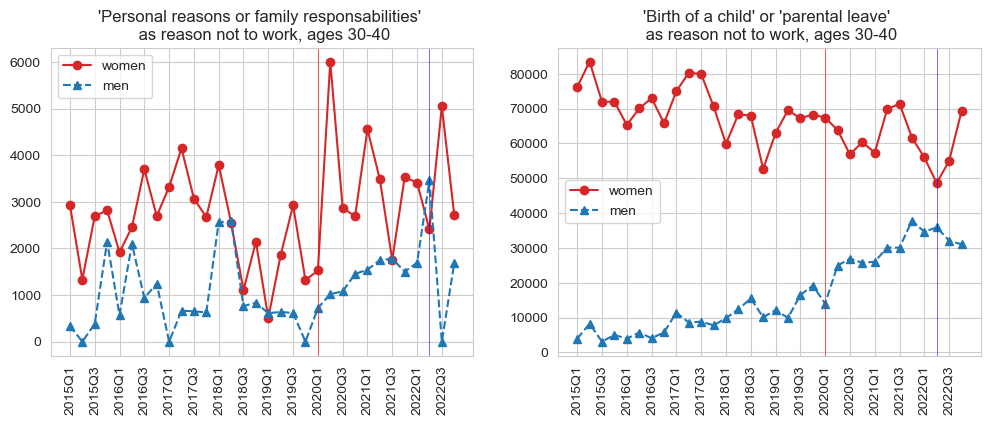

In [43]:
colors = sn.color_palette()
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title("'Personal reasons or family responsabilities' \n as reason not to work, ages 30-40")
plt.plot(razones_tab["Razones personales o responsabilidades familiares"].loc['2015Q1':],
         label='women',marker='o',c=colors[3])
plt.plot(razones_tab_m["Razones personales o responsabilidades familiares"].loc['2015Q1':],
         label='men',marker='^',ls='--',c=colors[0])
plt.xticks(razones_tab.loc['2015Q1':].index[::2],rotation=90)
plt.axvline('2020Q1',c='r',lw=0.4)
plt.axvline('2022Q2',c='b',lw=0.4)
plt.legend()

plt.subplot(122)
plt.title("'Birth of a child' or 'parental leave' \n as reason not to work, ages 30-40")
plt.plot(razones_tab["Excedencia por nacimiento de un hijo"].loc['2015Q1':]+razones_tab["Permiso por nacimiento de un hijo"].loc['2015Q1':],
         label='women',marker='o',c=colors[3])
plt.plot(razones_tab_m["Excedencia por nacimiento de un hijo"].loc['2015Q1':]+razones_tab_m["Permiso por nacimiento de un hijo"].loc['2015Q1':],
         label='men',marker='^',ls='--',c=colors[0])
plt.xticks(razones_tab.loc['2015Q1':].index[::2],rotation=90)
plt.axvline('2020Q1',c='r',lw=0.4)
plt.axvline('2022Q2',c='b',lw=0.4)
# plt.axvspan('2020Q1','2024Q4', alpha=0.1, lw=0)
# plt.axvspan('2007Q4','2014Q1', alpha=0.1, lw=0)
# plt.xlim(-1,len(razones_tab.index[t0:]))


plt.legend()

plt.show()

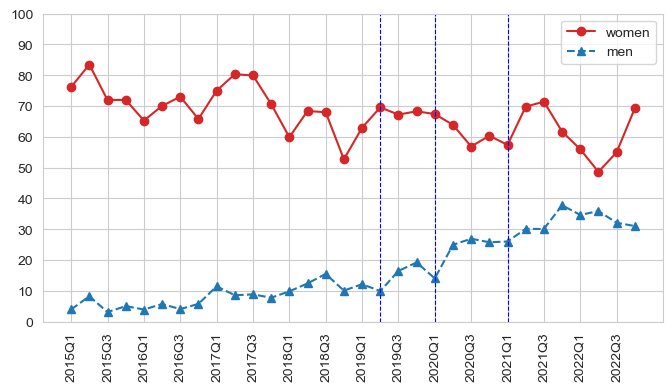

In [53]:
colors = sn.color_palette()
plt.figure(figsize=(8,4))

# plt.subplot(122)
# plt.title("'Birth of a child' or 'parental leave' as reason not to work, ages 30-40")
plt.plot(razones_tab["Excedencia por nacimiento de un hijo"].loc['2015Q1':]+razones_tab["Permiso por nacimiento de un hijo"].loc['2015Q1':],
         label='women',marker='o',c=colors[3])
plt.plot(razones_tab_m["Excedencia por nacimiento de un hijo"].loc['2015Q1':]+razones_tab_m["Permiso por nacimiento de un hijo"].loc['2015Q1':],
         label='men',marker='^',ls='--',c=colors[0])
plt.xticks(razones_tab.loc['2015Q1':].index[::2],rotation=90)
plt.yticks(np.arange(0,110e3,10e3),np.arange(0,110,10))
plt.axvline('2021Q1',c='b',lw=0.8,ls='--')
plt.axvline('2020Q1',c='b',lw=0.8,ls='--')
plt.axvline('2019Q2',c='b',lw=0.8,ls='--')
# plt.axvspan('2020Q1','2024Q4', alpha=0.1, lw=0)
# plt.axvspan('2007Q4','2014Q1', alpha=0.1, lw=0)
# plt.xlim(-1,len(razones_tab.index[t0:]))
plt.ylim(0,100e3)
plt.legend()
plt.savefig('./descriptive_stats/parental_leave.pdf',format='pdf',bbox_inches='tight')
plt.show()

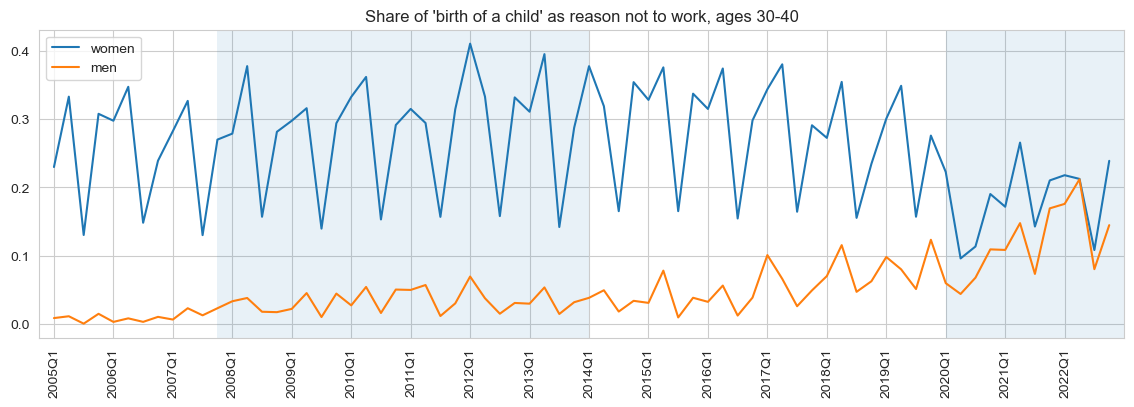

In [65]:
plt.figure(figsize=(14,4))
plt.plot((razones_tab["Excedencia por nacimiento de un hijo"]+razones_tab["Permiso por nacimiento de un hijo"]) / razones_tab['total'],label='women')
plt.plot((razones_tab_m["Excedencia por nacimiento de un hijo"]+razones_tab_m["Permiso por nacimiento de un hijo"]) / razones_tab_m['total'],label='men')
plt.xticks(razones_tab.index[::4],rotation=90)
plt.axvspan('2020Q1','2024Q4', alpha=0.1, lw=0)
plt.axvspan('2007Q4','2014Q1', alpha=0.1, lw=0)
plt.xlim(-1,len(razones_tab.index))
plt.legend()
plt.title("Share of 'birth of a child' as reason not to work, ages 30-40")
plt.show()

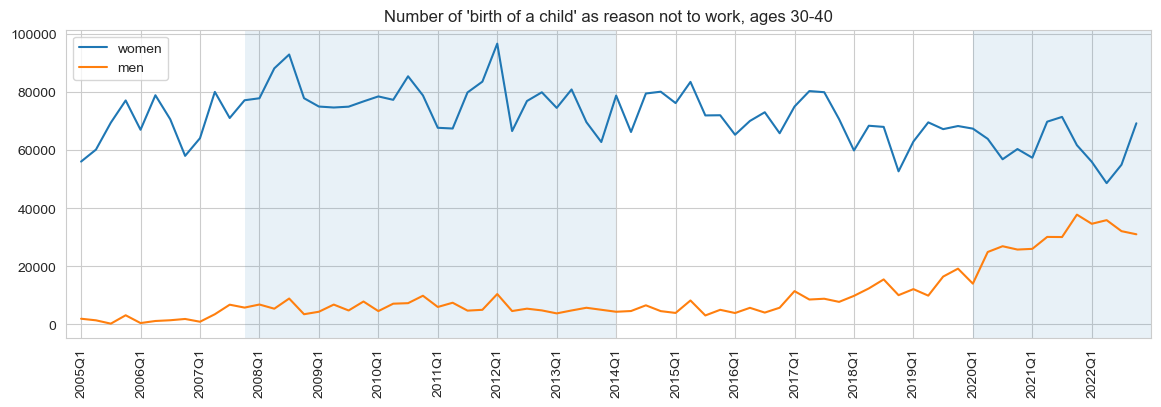

In [61]:
plt.figure(figsize=(14,4))
plt.plot(razones_tab["Excedencia por nacimiento de un hijo"]+razones_tab["Permiso por nacimiento de un hijo"],label='women')
plt.plot(razones_tab_m["Excedencia por nacimiento de un hijo"]+razones_tab_m["Permiso por nacimiento de un hijo"],label='men')
plt.xticks(razones_tab.index[::4],rotation=90)
plt.axvspan('2020Q1','2024Q4', alpha=0.1, lw=0)
plt.axvspan('2007Q4','2014Q1', alpha=0.1, lw=0)
plt.xlim(-1,len(razones_tab.index))
plt.legend()
plt.title("Number of 'birth of a child' as reason not to work, ages 30-40")
plt.show()

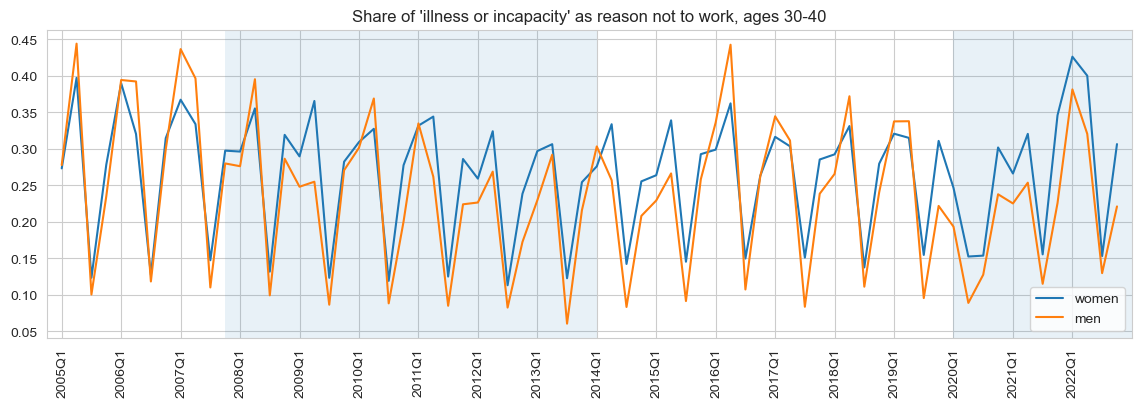

In [56]:
plt.figure(figsize=(14,4))
plt.plot(razones_tab["Enfermedad, accidente o incapacidad temporal del encuestado"]/razones_tab['total'],label='women')
plt.plot(razones_tab_m["Enfermedad, accidente o incapacidad temporal del encuestado"]/razones_tab_m['total'],label='men')
plt.xticks(razones_tab.index[::4],rotation=90)
plt.axvspan('2020Q1','2024Q4', alpha=0.1, lw=0)
plt.axvspan('2007Q4','2014Q1', alpha=0.1, lw=0)
plt.xlim(-1,len(razones_tab.index))
plt.legend()
plt.title("Share of 'illness or incapacity' as reason not to work, ages 30-40")
plt.show()

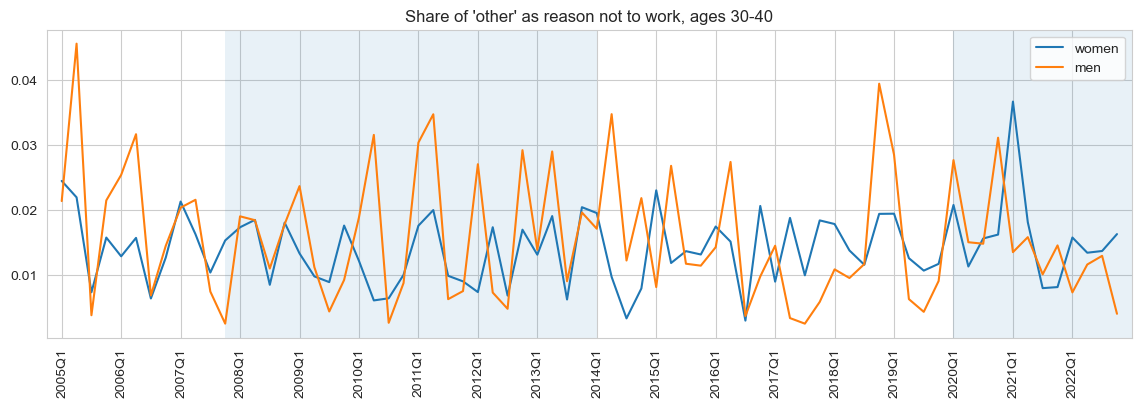

In [57]:
plt.figure(figsize=(14,4))
plt.plot(razones_tab["Otras razones"]/razones_tab['total'],label='women')
plt.plot(razones_tab_m["Otras razones"]/razones_tab_m['total'],label='men')
plt.xticks(razones_tab.index[::4],rotation=90)
plt.axvspan('2020Q1','2024Q4', alpha=0.1, lw=0)
plt.axvspan('2007Q4','2014Q1', alpha=0.1, lw=0)
plt.xlim(-1,len(razones_tab.index))
plt.legend()
plt.title("Share of 'other' as reason not to work, ages 30-40")
plt.show()

In [69]:
path="./descriptive_stats/"
file_split('rznotb_w_age3040_10_w.log',path,startwords=['ciclo',],endword="Total",header=None)
tab1 = read_table(path+'rznotb_w_age3040_10_w_1.log',ncols=7,rescale=100)
tab2 = read_table(path+'rznotb_w_age3040_10_w_2.log',ncols=7,rescale=100)
tab3 = read_table(path+'rznotb_w_age3040_10_w_3.log',ncols=2,rescale=100)

razones_tab_w10 = pd.concat((tab1,tab2,tab3),axis=1)
razones_tab_w10.rename(columns=reason_dict,inplace=True)
razones_tab_w10.rename(index=date_dict,inplace=True)
razones_tab_w10['total'] = np.sum(razones_tab_w10,axis=1)
razones_tab_w10.head()

,No sabe,Vacaciones o dias de permiso,Permiso por nacimiento de un hijo,Excedencia por nacimiento de un hijo,"Enfermedad, accidente o incapacidad temporal del encuestado","Jornada de verano, horario variable, flexible o similar",Actividades de representación sindical,Nuevo empleo en el que aún no había empezado a trabajar,Fijo discontinuo o trabajador estacional en la época de menor actividad,Mal tiempo,Paro parcial por razones técnicas o económicas,Se encuentra en expediente de regulación de empleo,Huelga o conflicto laboral,Haber recibido enseñanza o formación fuera del establecimiento,Razones personales o responsabilidades familiares,Otras razones,total
2005Q1,0.0,48709.51,30394.54,24009.61,40641.69,1125.14,0.0,0.00,1383.22,197.62,1065.93,0.00,0.00,0.0,1942.45,4563.05,154032.76
2005Q2,0.0,17357.15,29852.08,25402.02,38749.42,1063.05,0.0,571.72,1323.83,0.00,0.00,0.00,0.00,0.0,2540.63,2269.15,119129.05
2005Q3,0.0,206953.71,44113.73,24016.17,35808.23,769.08,0.0,997.93,3165.14,0.00,688.28,37.08,74.22,0.0,2429.39,2689.44,321742.40
2005Q4,0.0,36150.89,45679.73,28008.36,38449.57,1949.53,0.0,962.98,3392.34,192.92,0.00,0.00,553.49,417.8,1188.28,806.81,157752.70
2006Q1,0.0,24529.95,39953.13,25526.97,52061.39,722.77,0.0,1162.10,4114.95,160.70,440.42,0.00,0.00,0.0,2525.62,2300.92,153498.92


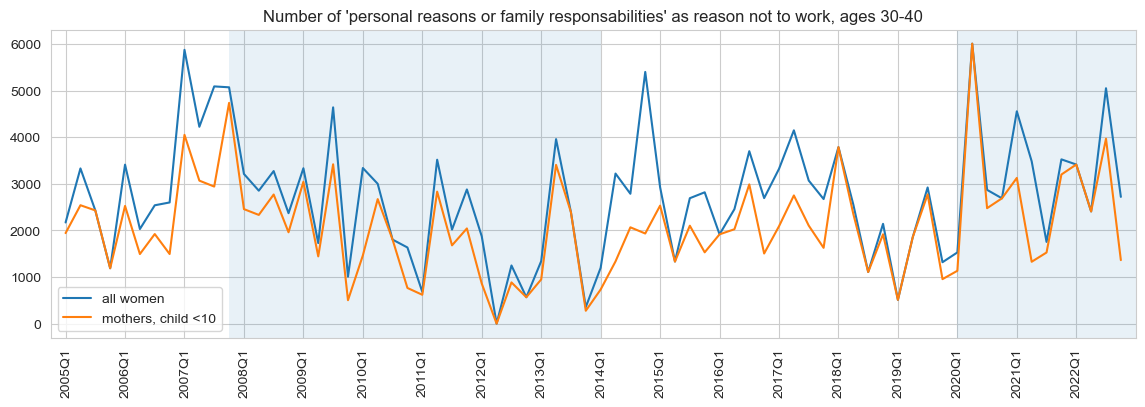

In [70]:
plt.figure(figsize=(14,4))
plt.plot(razones_tab["Razones personales o responsabilidades familiares"],label='all women')
plt.plot(razones_tab_w10["Razones personales o responsabilidades familiares"],label='mothers, child <10')
plt.xticks(razones_tab.index[::4],rotation=90)
plt.axvspan('2020Q1','2024Q4', alpha=0.1, lw=0)
plt.axvspan('2007Q4','2014Q1', alpha=0.1, lw=0)
plt.xlim(-1,len(razones_tab.index))
plt.legend()
plt.title("Number of 'personal reasons or family responsabilities' as reason not to work, ages 30-40")
plt.show()

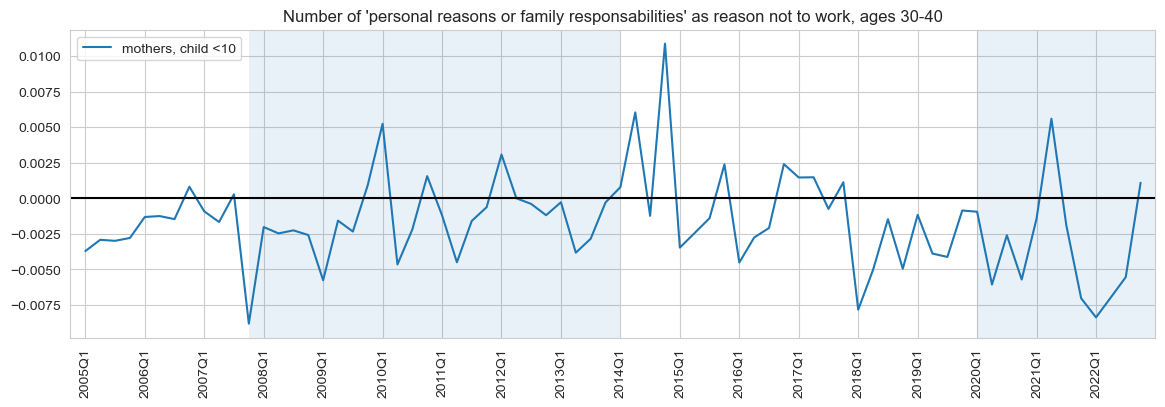

In [83]:
plt.figure(figsize=(14,4))
plt.plot(razones_tab["Razones personales o responsabilidades familiares"]/razones_tab['total']-\
razones_tab_w10["Razones personales o responsabilidades familiares"]/razones_tab_w10['total'],label='mothers, child <10')
plt.xticks(razones_tab.index[::4],rotation=90)
plt.axhline(c='k')
plt.axvspan('2020Q1','2024Q4', alpha=0.1, lw=0)
plt.axvspan('2007Q4','2014Q1', alpha=0.1, lw=0)
plt.xlim(-1,len(razones_tab.index))
plt.legend()
plt.title("Number of 'personal reasons or family responsabilities' as reason not to work, ages 30-40")
plt.show()

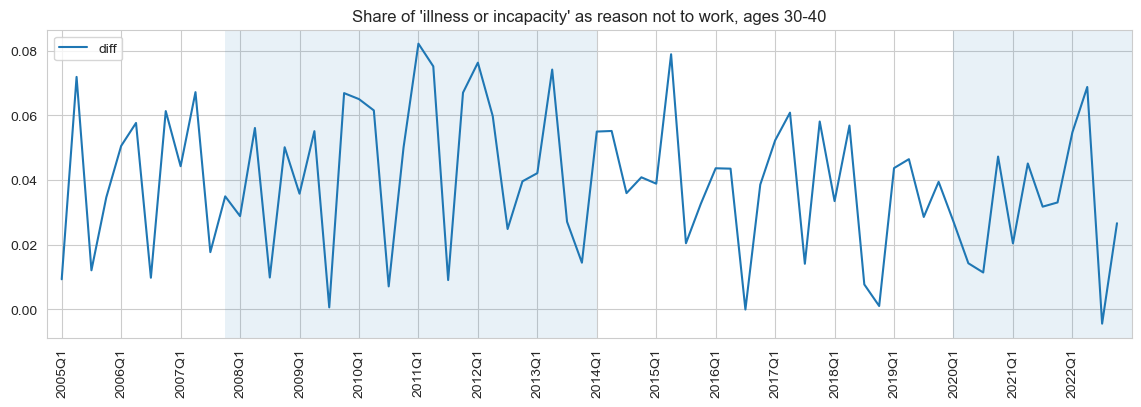

In [80]:
plt.figure(figsize=(14,4))
plt.plot(razones_tab["Enfermedad, accidente o incapacidad temporal del encuestado"]/razones_tab['total'] - \
razones_tab_w10["Enfermedad, accidente o incapacidad temporal del encuestado"]/razones_tab_w10['total'],label='diff')
plt.xticks(razones_tab.index[::4],rotation=90)
plt.axvspan('2020Q1','2024Q4', alpha=0.1, lw=0)
plt.axvspan('2007Q4','2014Q1', alpha=0.1, lw=0)
plt.xlim(-1,len(razones_tab.index))
plt.legend()
plt.title("Share of 'illness or incapacity' as reason not to work, ages 30-40")
plt.show()

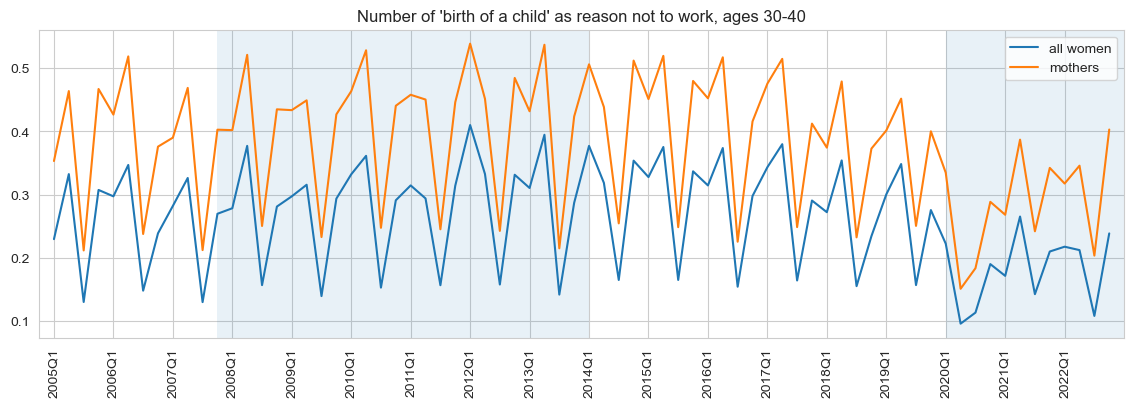

In [74]:
plt.figure(figsize=(14,4))
plt.plot((razones_tab["Excedencia por nacimiento de un hijo"]+razones_tab["Permiso por nacimiento de un hijo"])/razones_tab['total'],label='all women')
plt.plot((razones_tab_w10["Excedencia por nacimiento de un hijo"]+razones_tab_w10["Permiso por nacimiento de un hijo"])/razones_tab_w10['total'],label='mothers')
plt.xticks(razones_tab.index[::4],rotation=90)
plt.axvspan('2020Q1','2024Q4', alpha=0.1, lw=0)
plt.axvspan('2007Q4','2014Q1', alpha=0.1, lw=0)
plt.xlim(-1,len(razones_tab.index))
plt.legend()
plt.title("Number of 'birth of a child' as reason not to work, ages 30-40")
plt.show()

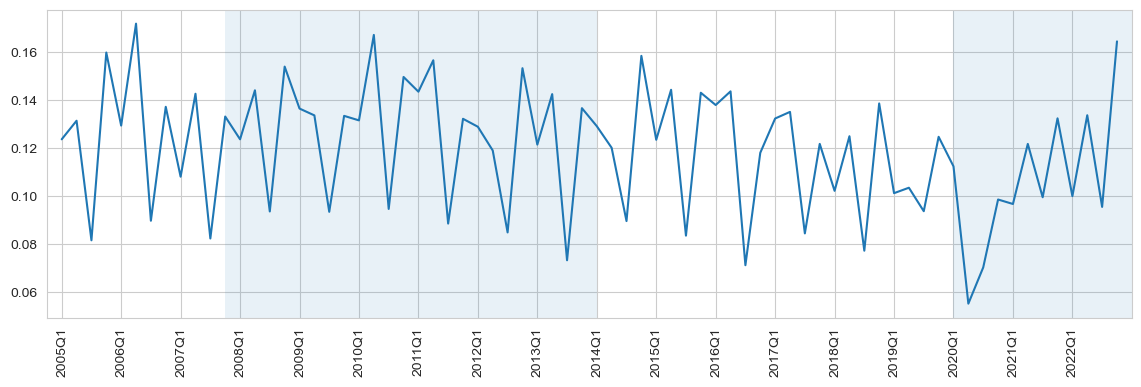

In [78]:
rzn_child_all = (razones_tab["Excedencia por nacimiento de un hijo"]+razones_tab["Permiso por nacimiento de un hijo"])/razones_tab['total']
rzn_child_moms = (razones_tab_w10["Excedencia por nacimiento de un hijo"]+razones_tab_w10["Permiso por nacimiento de un hijo"])/razones_tab_w10['total']

plt.figure(figsize=(14,4))
plt.plot(rzn_child_moms-rzn_child_all)
plt.xticks(razones_tab.index[::4],rotation=90)
plt.axvspan('2020Q1','2024Q4', alpha=0.1, lw=0)
plt.axvspan('2007Q4','2014Q1', alpha=0.1, lw=0)
plt.xlim(-1,len(razones_tab.index))
# plt.legend()
plt.show()

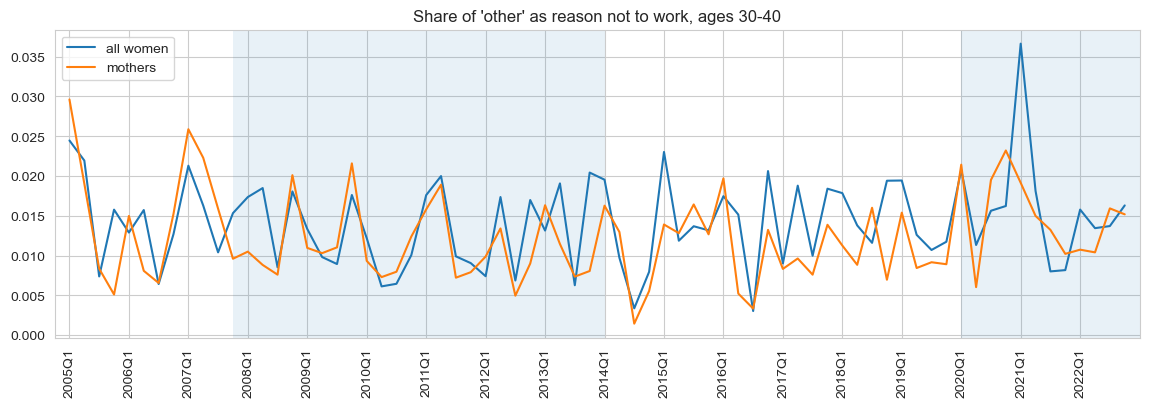

In [73]:
plt.figure(figsize=(14,4))
plt.plot(razones_tab["Otras razones"]/razones_tab['total'],label='all women')
plt.plot(razones_tab_w10["Otras razones"]/razones_tab_w10['total'],label='mothers')
plt.xticks(razones_tab.index[::4],rotation=90)
plt.axvspan('2020Q1','2024Q4', alpha=0.1, lw=0)
plt.axvspan('2007Q4','2014Q1', alpha=0.1, lw=0)
plt.xlim(-1,len(razones_tab.index))
plt.legend()
plt.title("Share of 'other' as reason not to work, ages 30-40")
plt.show()

### For OLF people

In [42]:
reasons_men_1518 = read_table(path+'reasons_men_1518.log',keyword='rznotb',ncols=2,rescale=100,index_to_int=False)
reasons_men_1922 = read_table(path+'reasons_men_1922.log',keyword='rznotb',ncols=2,rescale=100,index_to_int=False)

share_reasons_men_1518 = reasons_men_1518/np.sum(reasons_men_1518)
share_reasons_men_1518.rename(index=reason_dict,inplace=True)

share_reasons_men_1922 = reasons_men_1922/np.sum(reasons_men_1922)
share_reasons_men_1922.rename(index=reason_dict,inplace=True)

# share_reasons_men_1922['1']

In [47]:
reasons_m_tab_i = pd.concat((share_reasons_men_1518['1'].rename("2015-2018"),
                                              share_reasons_men_1922['1'].rename("2019-2022")),axis=1)

In [46]:
reasons_m_tab_e = pd.concat((share_reasons_men_1518['0'].rename("2015-2018"),
                                              share_reasons_men_1922['0'].rename("2019-2022")),axis=1)

In [48]:
pd.concat((reasons_m_tab_i,reasons_m_tab_e),axis=1,keys=('Inactive','Employed'))

Inactive            \
                                                   2015-2018 2019-2022   
No sabe                                             0.003768  0.000924   
Vacaciones o dias de permiso                        0.000000  0.000000   
Permiso por nacimiento de un hijo                   0.000000  0.000000   
Excedencia por nacimiento de un hijo                0.030571  0.012805   
Enfermedad, accidente o incapacidad temporal de...  0.000000  0.000000   
Jornada de verano, horario variable, flexible o...  0.006818  0.000212   
Actividades de representación sindical              0.000640  0.000178   
Nuevo empleo en el que aún no había empezado a ...  0.054003  0.022542   
Fijo discontinuo o trabajador estacional en la ...  0.670229  0.195908   
Mal tiempo                                          0.000701  0.000000   
Paro parcial por razones técnicas o económicas      0.022632  0.119866   
Se encuentra en expediente de regulación de empleo  0.048595  0.547779   
Huelga o conflicto laboral                          0.007131  0.001900   
Haber recibido enseñanza o formación fuera del ...  0.004536  0.001473   
Razones personales o responsabilidades familiares   0.039501  0.022792   
Otras razones                                       0.110874  0.073622   

                                                    Employed            
                                                   2015-2018 2019-2022  
No sabe                                             0.000263  0.000873  
Vacaciones o dias de permiso                        0.664587  0.484513  
Permiso por nacimiento de un hijo                   0.018225  0.045051  
Excedencia por nacimiento de un hijo                0.001170  0.001948  
Enfermedad, accidente o incapacidad temporal de...  0.243237  0.232601  
Jornada de verano, horario variable, flexible o...  0.009651  0.007609  
Actividades de representación sindical              0.000051  0.000036  
Nuevo empleo en el que aún no había empezado a ...  0.006320  0.006507  
Fijo discontinuo o trabajador estacional en la ...  0.013479  0.013879  
Mal tiempo                                          0.004055  0.002415  
Paro parcial por razones técnicas o económicas      0.018340  0.079985  
Se encuentra en expediente de regulación de empleo  0.002014  0.108263  
Huelga o conflicto laboral                          0.000306  0.000883  
Haber recibido enseñanza o formación fuera del ...  0.001147  0.000935  
Razones personales o responsabilidades familiares   0.004261  0.002900  
Otras razones                                       0.012894  0.011601

In [69]:
path="./descriptive_stats/"
name = "rznotb_inac_m_age3040_w"
file_split(name+'.log',path,startwords=['ciclo',],endword="Total",header=None)
tab1 = read_table(path+name+"_1.log",ncols=7,rescale=100)
tab2 = read_table(path+name+"_2.log",ncols=6,rescale=100)

razones_tab_m = pd.concat((tab1,tab2),axis=1)
razones_tab_m.rename(columns=reason_dict,inplace=True)
razones_tab_m.rename(index=date_dict,inplace=True)
razones_tab_m.head()

,No sabe,Excedencia por nacimiento de un hijo,"Jornada de verano, horario variable, flexible o similar",Actividades de representación sindical,Nuevo empleo en el que aún no había empezado a trabajar,Fijo discontinuo o trabajador estacional en la época de menor actividad,Mal tiempo,Paro parcial por razones técnicas o económicas,Se encuentra en expediente de regulación de empleo,Huelga o conflicto laboral,Haber recibido enseñanza o formación fuera del establecimiento,Razones personales o responsabilidades familiares,Otras razones
2005Q1,194.98,0.0,0.0,0.0,383.78,4163.04,0.00,0.0,1256.69,172.33,0.0,194.13,165.64
2005Q2,0.00,0.0,0.0,0.0,1416.51,2809.74,0.00,0.0,0.00,224.73,0.0,0.00,635.94
2005Q3,139.69,0.0,0.0,0.0,891.58,954.25,0.00,0.0,0.00,443.54,0.0,421.72,0.00
2005Q4,0.00,0.0,0.0,0.0,0.00,2976.52,176.37,0.0,0.00,326.91,0.0,487.44,90.40
2006Q1,0.00,0.0,0.0,267.9,605.14,1548.15,0.00,0.0,0.00,0.00,0.0,0.00,325.66


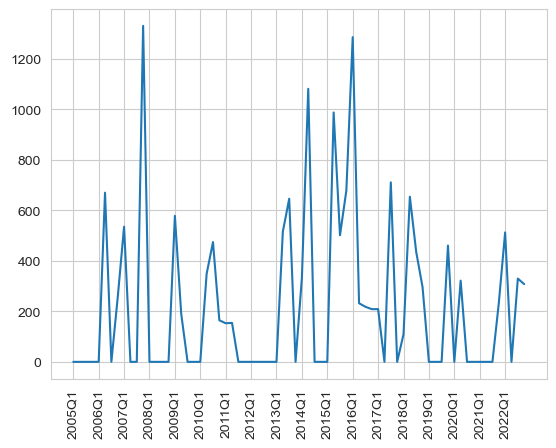

In [70]:
plt.plot(razones_tab_m["Excedencia por nacimiento de un hijo"])
plt.xticks(razones_tab_m.index[::4],rotation=90)
plt.show()

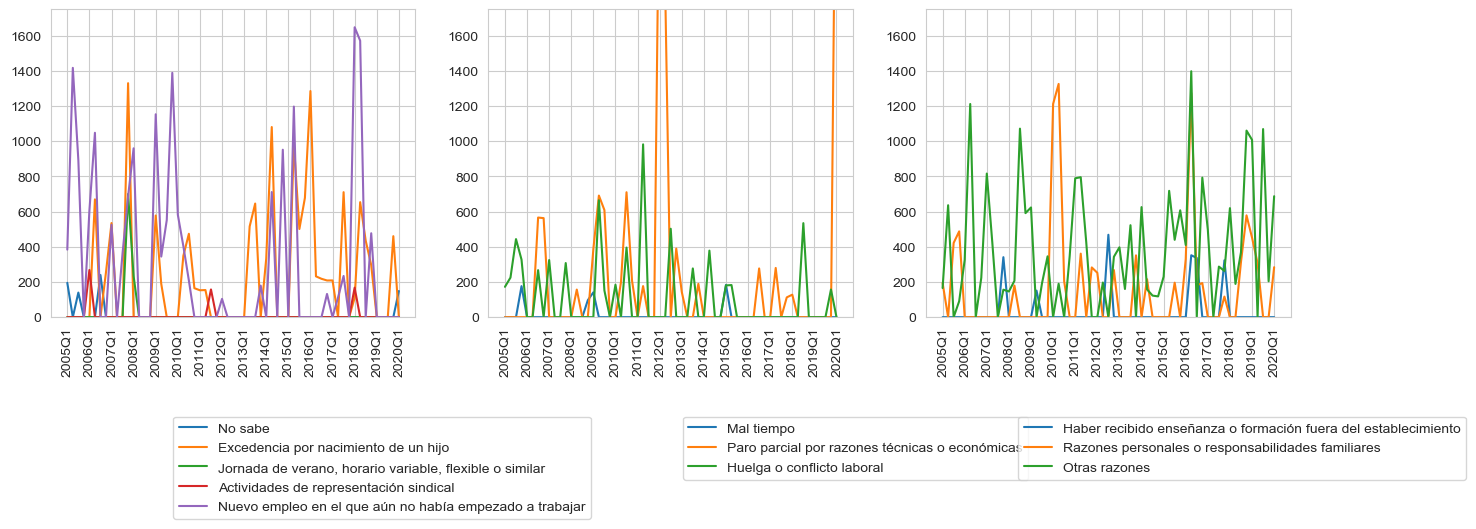

In [106]:
pi = 0
plt.figure(figsize=(16,4))
for i,reason in enumerate(razones_tab_m.keys()):
    plt.subplot(131+pi)
    if reason in ['Se encuentra en expediente de regulación de empleo',
                  'Fijo discontinuo o trabajador estacional en la época de menor actividad']:
        pass
    else:
        plt.plot(razones_tab_m[reason].loc[:'2020Q1'],label=reason)
    if (i+1)%5==0:
        plt.xticks(razones_tab_m.index[:-8:4],rotation=90)
        plt.legend(bbox_to_anchor=(1.5,-0.3))
        plt.ylim(0,1750)
        pi+=1
plt.xticks(razones_tab_m.index[:-8:4],rotation=90)
plt.legend(bbox_to_anchor=(1.5,-0.3))
plt.ylim(0,1750)
plt.show()

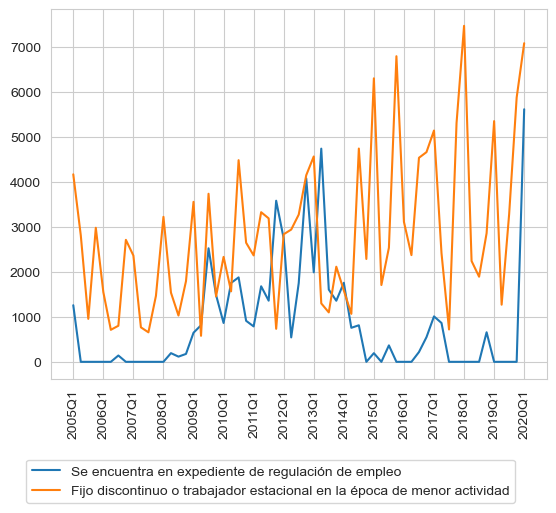

In [110]:
for reason in ['Se encuentra en expediente de regulación de empleo',
                  'Fijo discontinuo o trabajador estacional en la época de menor actividad']:
    plt.plot(razones_tab_m[reason].loc[:'2020Q1'],label=reason)
plt.xticks(razones_tab_m.index[:-8:4],rotation=90)
plt.legend(bbox_to_anchor=(0.95,-0.2))
# plt.ylim(0,1750)
plt.show()

In [111]:
path="./descriptive_stats/"
name = "rznotb_inac_husbands_age3040_w"
file_split(name+'.log',path,startwords=['ciclo',],endword="Total",header=None)
tab1 = read_table(path+name+"_1.log",ncols=7,rescale=100)
tab2 = read_table(path+name+"_2.log",ncols=6,rescale=100)

razones_tab_h = pd.concat((tab1,tab2),axis=1)
razones_tab_h.rename(columns=reason_dict,inplace=True)
razones_tab_h.rename(index=date_dict,inplace=True)
razones_tab_h.head()

,No sabe,Excedencia por nacimiento de un hijo,"Jornada de verano, horario variable, flexible o similar",Actividades de representación sindical,Nuevo empleo en el que aún no había empezado a trabajar,Fijo discontinuo o trabajador estacional en la época de menor actividad,Mal tiempo,Paro parcial por razones técnicas o económicas,Se encuentra en expediente de regulación de empleo,Huelga o conflicto laboral,Haber recibido enseñanza o formación fuera del establecimiento,Razones personales o responsabilidades familiares,Otras razones
2005Q1,0.00,0.0,0.0,0.0,209.35,2008.20,0.0,0.0,1256.69,0.0,0.0,194.13,165.64
2005Q2,0.00,0.0,0.0,0.0,1416.51,981.29,0.0,0.0,0.00,0.0,0.0,0.00,146.94
2005Q3,139.69,0.0,0.0,0.0,891.58,263.02,0.0,0.0,0.00,0.0,0.0,0.00,0.00
2005Q4,0.00,0.0,0.0,0.0,0.00,2409.34,0.0,0.0,0.00,0.0,0.0,0.00,90.40
2006Q1,0.00,0.0,0.0,0.0,297.63,402.01,0.0,0.0,0.00,0.0,0.0,0.00,0.00


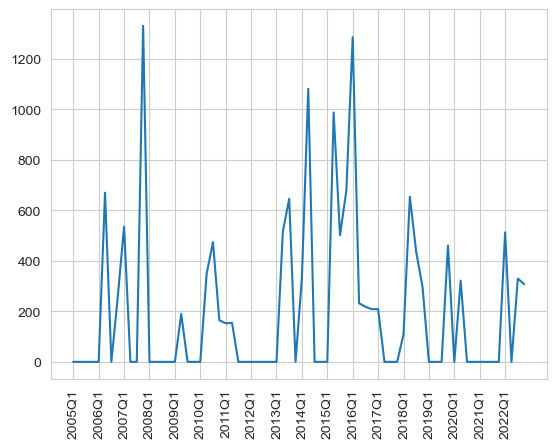

In [112]:
plt.plot(razones_tab_h["Excedencia por nacimiento de un hijo"])
plt.xticks(razones_tab_h.index[::4],rotation=90)
plt.show()

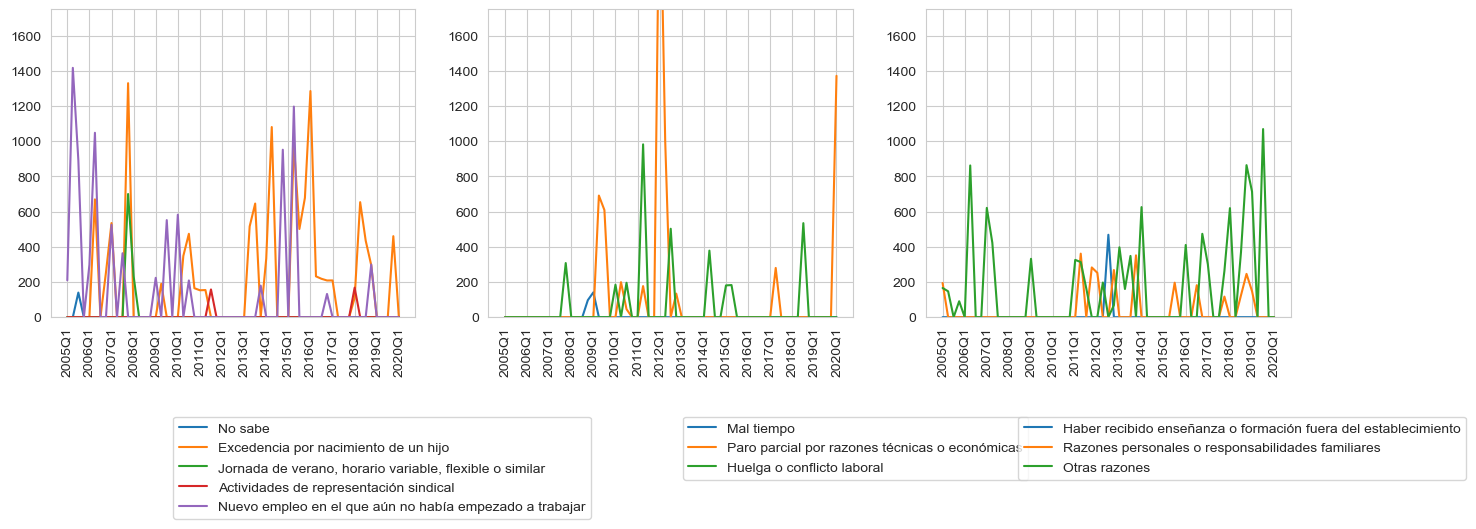

In [113]:
pi = 0
plt.figure(figsize=(16,4))
for i,reason in enumerate(razones_tab_h.keys()):
    plt.subplot(131+pi)
    if reason in ['Se encuentra en expediente de regulación de empleo',
                  'Fijo discontinuo o trabajador estacional en la época de menor actividad']:
        pass
    else:
        plt.plot(razones_tab_h[reason].loc[:'2020Q1'],label=reason)
    if (i+1)%5==0:
        plt.xticks(razones_tab_h.index[:-8:4],rotation=90)
        plt.legend(bbox_to_anchor=(1.5,-0.3))
        plt.ylim(0,1750)
        pi+=1
plt.xticks(razones_tab_h.index[:-8:4],rotation=90)
plt.legend(bbox_to_anchor=(1.5,-0.3))
plt.ylim(0,1750)
plt.show()

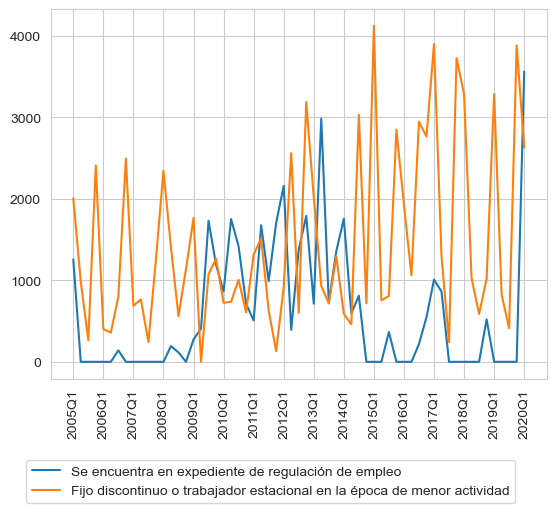

In [114]:
for reason in ['Se encuentra en expediente de regulación de empleo',
                  'Fijo discontinuo o trabajador estacional en la época de menor actividad']:
    plt.plot(razones_tab_h[reason].loc[:'2020Q1'],label=reason)
plt.xticks(razones_tab_h.index[:-8:4],rotation=90)
plt.legend(bbox_to_anchor=(0.95,-0.2))
# plt.ylim(0,1750)
plt.show()

In [122]:
path="./descriptive_stats/"
name = "rznotb_emp_husbands_age3040_w"
file_split(name+'.log',path,startwords=['ciclo',],endword="Total",header=None)
tab1 = read_table(path+name+"_1.log",ncols=7,rescale=100)
tab2 = read_table(path+name+"_2.log",ncols=7,rescale=100)
tab3 = read_table(path+name+"_3.log",ncols=1,rescale=100)

razones_tab_e = pd.concat((tab1,tab2,tab3),axis=1)
razones_tab_e.rename(columns=reason_dict,inplace=True)
razones_tab_e.rename(index=date_dict,inplace=True)
razones_tab_e.head()

,No sabe,Vacaciones o dias de permiso,Permiso por nacimiento de un hijo,Excedencia por nacimiento de un hijo,"Enfermedad, accidente o incapacidad temporal del encuestado","Jornada de verano, horario variable, flexible o similar",Actividades de representación sindical,Fijo discontinuo o trabajador estacional en la época de menor actividad,Mal tiempo,Paro parcial por razones técnicas o económicas,Se encuentra en expediente de regulación de empleo,Huelga o conflicto laboral,Haber recibido enseñanza o formación fuera del establecimiento,Razones personales o responsabilidades familiares,Otras razones
2005Q1,0.0,74170.84,1048.74,729.37,32268.91,1759.42,277.39,0.0,779.12,1047.15,0.00,0.00,0.0,285.63,370.38
2005Q2,0.0,28496.51,1172.45,0.00,30710.87,1372.93,0.00,0.0,0.00,1511.98,0.00,0.00,0.0,115.22,1572.59
2005Q3,0.0,257996.32,0.00,277.91,30481.04,158.78,0.00,0.0,0.00,0.00,160.47,266.03,0.0,0.00,331.20
2005Q4,0.0,86471.77,3161.22,0.00,29092.61,1193.78,0.00,0.0,0.00,335.51,0.00,0.00,0.0,310.26,1919.52
2006Q1,0.0,41507.02,352.56,0.00,30476.45,694.76,123.75,0.0,720.18,891.64,638.58,0.00,0.0,324.91,329.12


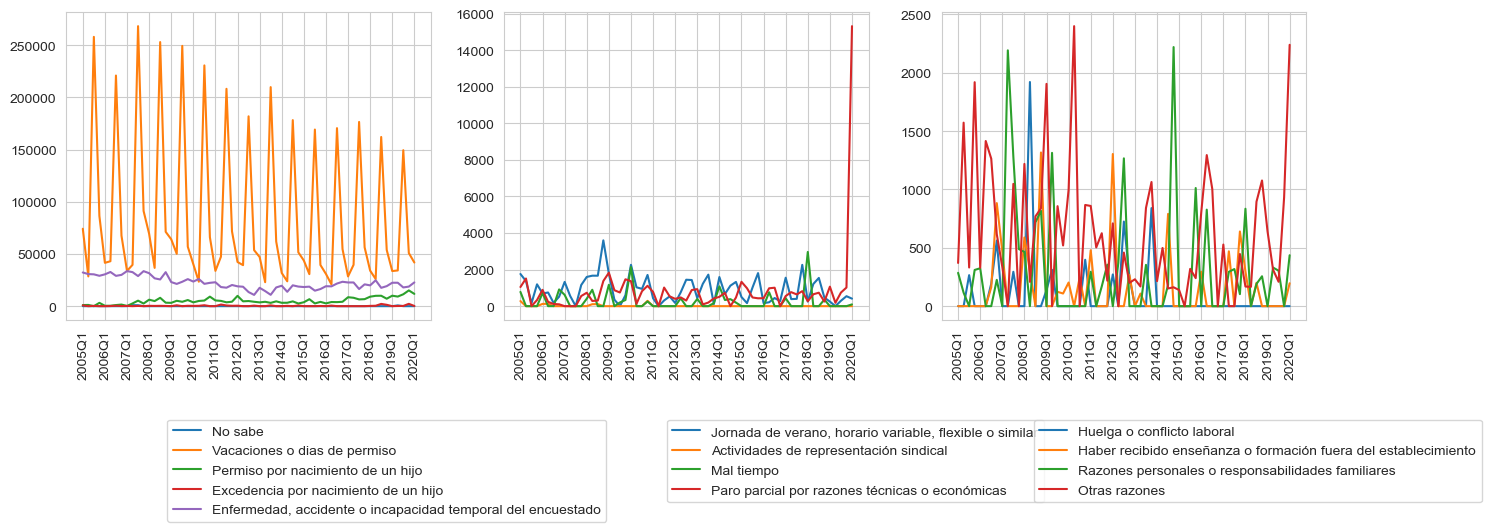

In [124]:
pi = 0
plt.figure(figsize=(16,4))
for i,reason in enumerate(razones_tab_e.keys()):
    plt.subplot(131+pi)
    if reason in ['Se encuentra en expediente de regulación de empleo',
                  'Fijo discontinuo o trabajador estacional en la época de menor actividad']:
        pass
    else:
        plt.plot(razones_tab_e[reason].loc[:'2020Q1'],label=reason)
    if (i+1)%5==0:
        plt.xticks(razones_tab_e.index[:-8:4],rotation=90)
        plt.legend(bbox_to_anchor=(1.5,-0.3))
#         plt.ylim(0,1750)
        pi+=1
plt.xticks(razones_tab_e.index[:-8:4],rotation=90)
plt.legend(bbox_to_anchor=(1.5,-0.3))
# plt.ylim(0,1750)
plt.show()